In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from src.lfw import LFW
lfw = LFW('../../storage/lfw', test_sample=0.2, limit_to_A=False)
lfw_limit = LFW('../../storage/lfw', test_sample=0.2, limit_to_A=True)

In [3]:
#from src.eval import Eval
evaluator = Eval(train_data=lfw.train_data, test_data=lfw.test_data)
evaluator_limit = Eval(train_data=lfw_limit.train_data, test_data=lfw_limit.test_data)

NameError: name 'Eval' is not defined

# Representation with VGG16

In [5]:
pretrained_rep = torchvision.models.vgg16(pretrained=True)
pretrained_rep = pretrained_rep.to(device)
pretrained_rep.classifier[4] = nn.Sequential()
pretrained_rep.classifier[5] = nn.Sequential()
pretrained_rep.classifier[6] = nn.Sequential()

In [18]:
print(evaluator_limit.eval_rep(pretrained_rep))
print(evaluator_limit.topn_acc(5))

0.1619047619047619
0.34285714285714286


In [19]:
print(evaluator.eval_rep(pretrained_rep))
print(evaluator.topn_acc(5))

0.08570330514988471
0.17102229054573406


# Attribute learning
## upper bound

In [21]:
from sklearn.neighbors import KNeighborsClassifier

outputs = []
clazzes = []

for _, clazz, attributes, _ in lfw.train_data:
    outputs.append(attributes)
    clazzes.append(clazz)

o = np.stack(outputs)
c = np.array(clazzes)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, c)

correct = 0
num = 0
for _, clazz, attributes, _ in lfw.test_data:
    pred = knn.predict(attributes.reshape(1, -1))
    pred = torch.tensor(pred)
    correct += torch.sum(np.equal(pred, clazz))
    num += 1

print(correct.item() / num)

0.19254419677171405


#### limit

In [25]:
outputs = []
clazzes = []

for _, clazz, attributes, _ in lfw_limit.train_data:
    outputs.append(attributes)
    clazzes.append(clazz)

o = np.stack(outputs)
c = np.array(clazzes)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, c)

correct = 0
num = 0
for _, clazz, attributes, _ in lfw_limit.test_data:
    pred = knn.predict(attributes.reshape(1, -1))
    pred = torch.tensor(pred)
    correct += torch.sum(np.equal(pred, clazz))
    num += 1

print(correct.item() / num)

0.37142857142857144


#### top5 accuracy

In [37]:
outputs = []
clazzes = []

for _, clazz, attributes, _ in lfw.train_data:
    outputs.append(attributes)
    clazzes.append(clazz)

o = np.stack(outputs)
c = np.array(clazzes)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, c)

correct = 0
num = 0
for _, clazz, attributes, _ in lfw.test_data:
    pred = knn.kneighbors(attributes.reshape(1, -1), n_neighbors=5, return_distance=False)
    pred = [c[i] for i in pred[0]]
    correct += clazz in pred
    num += 1

print(correct / num)

0.31475787855495774


In [43]:
outputs = []
clazzes = []

for _, clazz, attributes, _ in lfw_limit.train_data:
    outputs.append(attributes)
    clazzes.append(clazz)

o = np.stack(outputs)
c = np.array(clazzes)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, c)

correct = 0
num = 0
for _, clazz, attributes, _ in lfw_limit.test_data:
    pred = knn.kneighbors(attributes.reshape(1, -1), n_neighbors=5, return_distance=False)
    pred = [c[i] for i in pred[0]]
    correct += clazz in pred
    num += 1

print(correct / num)

0.5904761904761905


### average per person

In [19]:
from sklearn.neighbors import KNeighborsClassifier

outputs = []

for _, clazz, attributes, _ in lfw.train_data:
    if len(outputs) < clazz+1:
        outputs.append([])
    outputs[clazz].append(attributes)
    
o = []

for num, outs in enumerate(outputs):
    out = torch.stack(outs)
    o.append(torch.mean(out, dim=0).numpy())

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, list(range(len(o))))

correct = 0
num = 0
for _, clazz, attributes, _ in lfw.test_data:
    pred = knn.predict(attributes.reshape(1, -1))
    pred = torch.tensor(pred)
    correct += torch.sum(np.equal(pred, clazz)).item()
    num += 1

print(correct / num)

0.15295926210607225


#### limit

In [41]:
outputs = []2

for _, clazz, attributes, _ in lfw_limit.train_data:
    if len(outputs) < clazz+1:
        outputs.append([])
    outputs[clazz].append(attributes)
    
o = []

for num, outs in enumerate(outputs):
    out = torch.stack(outs)
    o.append(torch.mean(out, dim=0).numpy())

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, list(range(len(o))))

correct = 0
num = 0
for _, clazz, attributes, _ in lfw_limit.test_data:
    pred = knn.predict(attributes.reshape(1, -1))
    pred = torch.tensor(pred)
    correct += torch.sum(np.equal(pred, clazz)).item()
    num += 1

print(correct / num)

0.3952380952380952


#### top5

In [40]:
outputs = []

for _, clazz, attributes, _ in lfw.train_data:
    if len(outputs) < clazz+1:
        outputs.append([])
    outputs[clazz].append(attributes)
    
o = []

for num, outs in enumerate(outputs):
    out = torch.stack(outs)
    o.append(torch.mean(out, dim=0).numpy())

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(o, list(range(len(o))))

correct = 0
num = 0
for _, clazz, attributes, _ in lfw.test_data:
    pred = knn.kneighbors(attributes.reshape(1, -1), n_neighbors=5, return_distance=False)
    correct += clazz in pred[0]
    num += 1

print(correct / num)

0.28670253651037664


## full training

In [5]:
attr_rep = torchvision.models.vgg16(pretrained=True)
attr_rep.classifier[6] = nn.Linear(in_features=4096, out_features=lfw.targets.shape[1])
attr_rep = attr_rep.to(device)

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(lfw.train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(lfw.test_data, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(attr_rep.parameters(), lr=0.001)
criterion = nn.MSELoss()

for i in range(10):
    print("Epoch {}".format(i))
    
    attr_rep.train()
    running_loss = 0.0
    for index, (images, clazz, attributes) in enumerate(train_loader):
        images = images.to(device)
        attributes = attributes.to(device)
        optimizer.zero_grad()
        outputs = attr_rep(images)
        loss = criterion(outputs, attributes)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    print('Loss: {:.4f}'.format(epoch_loss))
    
    attr_rep.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, clazz, attributes in test_loader:
            images = images.to(device)
            attributes = attributes.to(device)
            outputs = attr_rep(images)
            loss = criterion(outputs, attributes)
            running_val_loss += loss.item() * images.size(0)
            
    val_loss = running_val_loss / len(test_loader)
    print('Val Loss: {:.4f}'.format(val_loss))

Epoch 0
Loss: 9.7221
Val Loss: 9.6407
Epoch 1
Loss: 9.7215
Val Loss: 9.6053
Epoch 2
Loss: 9.5672
Val Loss: 9.2945
Epoch 3
Loss: 9.5154
Val Loss: 9.2589
Epoch 4
Loss: 9.3937
Val Loss: 8.9976
Epoch 5
Loss: 9.2625
Val Loss: 8.9872
Epoch 6
Loss: 9.2607
Val Loss: 9.0377
Epoch 7
Loss: 9.2415
Val Loss: 8.8828
Epoch 8
Loss: 9.2123
Val Loss: 9.0511
Epoch 9
Loss: 9.0653
Val Loss: 8.7943


In [21]:
evaluator.eval_rep(attr_rep)

0.061491160645657184

In [9]:
evaluator.eval_rep(attr_rep)

0.06725595695618755

In [23]:
evaluator_limit.eval_rep(attr_rep)

0.23333333333333334

In [15]:
torch.save(attr_rep.state_dict(), "./attr_rep.model")

In [6]:
attr_rep.load_state_dict(torch.load("./attr_rep.model"))

<All keys matched successfully>

## train only last layer

In [13]:
attr_rep = torchvision.models.vgg16(pretrained=True)
for param in attr_rep.parameters():
    param.require_grad = False
attr_rep.classifier[6] = nn.Linear(in_features=4096, out_features=lfw.targets.shape[1])
attr_rep = attr_rep.to(device)

In [25]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(lfw.train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(lfw.test_data, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(attr_rep.classifier[6].parameters(), lr=0.0001)
criterion = nn.MSELoss()

for i in range(5):
    print("Epoch {}".format(i))
    
    attr_rep.train()
    running_loss = 0.0
    for index, (images, clazz, attributes) in enumerate(train_loader):
        images = images.to(device)
        attributes = attributes.to(device)
        optimizer.zero_grad()
        outputs = attr_rep(images)
        loss = criterion(outputs, attributes)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    print('Loss: {:.4f}'.format(epoch_loss))
    
    running_val_loss = 0.0
    attr_rep.eval()
    with torch.no_grad():
        for images, clazz, attributes in test_loader:
            images = images.to(device)
            attributes = attributes.to(device)
            outputs = attr_rep(images)
            loss = criterion(outputs, attributes)
            running_val_loss += loss.item() * images.size(0)
            
    val_loss = running_val_loss / len(test_loader)
    print('Val Loss: {:.4f}'.format(val_loss))

Epoch 0
Loss: 21.5717
Val Loss: 21.2980
Epoch 1
Loss: 21.5515
Val Loss: 21.2917
Epoch 2
Loss: 21.5393
Val Loss: 21.2916
Epoch 3
Loss: 21.5419
Val Loss: 21.2979
Epoch 4
Loss: 21.5219
Val Loss: 21.2958


In [26]:
evaluator.eval_rep(attr_rep)

0.005380476556495004

In [27]:
evaluator_limit.eval_rep(attr_rep)

0.04285714285714286

# Different models

In [20]:
pretrained_rep = torchvision.models.mobilenet_v2(pretrained=True)
pretrained_rep = pretrained_rep.to(device)
pretrained_rep.classifier = nn.Sequential()

In [25]:
print(evaluator.eval_rep(pretrained_rep))
print(evaluator.topn_acc(5))

0.13412759415833975
0.24327440430438124


In [7]:
evaluator_limit.eval_rep(pretrained_rep)

0.319047619047619

In [54]:
pretrained_rep = torchvision.models.alexnet(pretrained=True)
pretrained_rep = pretrained_rep.to(device)
#pretrained_rep.classifier[6] = nn.Sequential()

In [56]:
evaluator.eval_rep(pretrained_rep)

0.08147578785549578

In [55]:
evaluator_limit.eval_rep(pretrained_rep)

0.19523809523809524

In [48]:
pretrained_rep = torchvision.models.inception_v3(pretrained=True)
pretrained_rep = pretrained_rep.to(device)
pretrained_rep.fc = nn.Sequential()

In [50]:
evaluator.eval_rep(pretrained_rep)

0.09454265949269793

In [49]:
evaluator_limit.eval_rep(pretrained_rep)

0.21904761904761905

In [10]:
pretrained_rep = torchvision.models.resnet152(pretrained=True)
pretrained_rep = pretrained_rep.to(device)
pretrained_rep.fc = nn.Sequential()

In [7]:
evaluator.eval_rep(pretrained_rep)

0.12797847809377402

In [8]:
evaluator_limit.eval_rep(pretrained_rep)

0.2523809523809524

## mobilenet attributes

In [57]:
attr_rep = torchvision.models.mobilenet_v2(pretrained=True)
for param in attr_rep.parameters():
    param.require_grad = False
attr_rep.classifier = nn.Linear(in_features=1280, out_features=lfw.targets.shape[1])
attr_rep = attr_rep.to(device)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(lfw.train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(lfw.test_data, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(attr_rep.classifier.parameters(), lr=0.001)
criterion = nn.MSELoss()

for i in range(10):
    print("Epoch {}".format(i))
    
    attr_rep.train()
    running_loss = 0.0
    for index, (images, clazz, attributes) in enumerate(train_loader):
        images = images.to(device)
        attributes = attributes.to(device)
        optimizer.zero_grad()
        outputs = attr_rep(images)
        loss = criterion(outputs, attributes)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    print('Loss: {:.4f}'.format(epoch_loss))
    
    running_val_loss = 0.0
    attr_rep.eval()
    with torch.no_grad():
        for images, clazz, attributes in test_loader:
            images = images.to(device)
            attributes = attributes.to(device)
            outputs = attr_rep(images)
            loss = criterion(outputs, attributes)
            running_val_loss += loss.item() * images.size(0)
            
    val_loss = running_val_loss / len(test_loader)
    print('Val Loss: {:.4f}'.format(val_loss))

In [61]:
evaluator.eval_rep(attr_rep)

0.053036126056879324

In [62]:
attr_rep.classifier = nn.Sequential()
evaluator.eval_rep(attr_rep)

0.14757878554957723

In [63]:
evaluator_limit.eval_rep(attr_rep)

0.2857142857142857

In [27]:
attr_rep = torchvision.models.mobilenet_v2(pretrained=True)
attr_rep.classifier = nn.Linear(in_features=1280, out_features=lfw.targets.shape[1])
attr_rep = attr_rep.to(device)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(lfw.train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(lfw.test_data, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(attr_rep.parameters(), lr=0.001)
criterion = nn.MSELoss()

for i in range(1,51):
    print("Epoch {}".format(i))
    
    attr_rep.train()
    running_loss = 0.0
    for index, (images, clazz, attributes, _) in enumerate(train_loader):
        images = images.to(device)
        attributes = attributes.to(device)
        optimizer.zero_grad()
        outputs = attr_rep(images)
        loss = criterion(outputs, attributes)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    print('Loss: {:.4f}'.format(epoch_loss))
    
    running_val_loss = 0.0
    attr_rep.eval()
    with torch.no_grad():
        for _, clazz, attributes, images in test_loader:
            images = images.to(device)
            attributes = attributes.to(device)
            outputs = attr_rep(images)
            loss = criterion(outputs, attributes)
            running_val_loss += loss.item() * images.size(0)
            
    val_loss = running_val_loss / len(test_loader)
    print('Val Loss: {:.4f}'.format(val_loss))
    
    if i % 10 == 0:
        print("ACC: {:.3f}%".format(evaluator.eval_rep(attr_rep) * 100))

Epoch 1
Loss: 19.5515
Val Loss: 17.0482
Epoch 2
Loss: 15.8042
Val Loss: 16.1753
Epoch 3
Loss: 14.3209
Val Loss: 12.9282
Epoch 4
Loss: 13.0429
Val Loss: 12.0179
Epoch 5
Loss: 12.0378
Val Loss: 12.3963
Epoch 6
Loss: 11.3402
Val Loss: 11.1366
Epoch 7
Loss: 10.8672
Val Loss: 9.8921
Epoch 8
Loss: 10.3735
Val Loss: 10.5636
Epoch 9
Loss: 10.0590
Val Loss: 9.4662
Epoch 10
Loss: 9.7672
Val Loss: 9.7811
ACC: 12.990%
Epoch 11
Loss: 9.4807
Val Loss: 9.1077
Epoch 12
Loss: 9.2672
Val Loss: 9.9573
Epoch 13
Loss: 9.1628
Val Loss: 9.2639
Epoch 14
Loss: 8.9529
Val Loss: 8.4765
Epoch 15
Loss: 8.8087
Val Loss: 8.6012
Epoch 16
Loss: 8.6395
Val Loss: 8.1705
Epoch 17
Loss: 8.4705
Val Loss: 8.2167
Epoch 18
Loss: 8.3934
Val Loss: 8.6883
Epoch 19
Loss: 8.2126
Val Loss: 7.6860
Epoch 20
Loss: 8.1529
Val Loss: 7.4701
ACC: 14.950%
Epoch 21
Loss: 8.0739
Val Loss: 8.0944
Epoch 22
Loss: 7.9128
Val Loss: 7.2943
Epoch 23
Loss: 7.7856
Val Loss: 7.8793
Epoch 24
Loss: 7.7331
Val Loss: 7.6161
Epoch 25
Loss: 7.5935
Val Loss:

In [104]:
print(evaluator.eval_rep(attr_rep))
print(evaluator.topk_acc(5))

0.20561106840891621
0.33166794773251346


In [21]:
evaluator_limit.eval_rep(attr_rep)

0.3904761904761905

In [13]:
torch.save(attr_rep.state_dict(), "./attr_rep_mobilenetv2.model")

In [100]:
attr_rep = torchvision.models.mobilenet_v2(pretrained=True)
attr_rep.classifier = nn.Linear(in_features=1280, out_features=lfw.targets.shape[1])
attr_rep = attr_rep.to(device)
attr_rep.load_state_dict(torch.load("./attr_rep_mobilenetv2.model"))

<All keys matched successfully>

### trained model representation

In [28]:
attr_rep.classifier = nn.Sequential()
print(evaluator.eval_rep(attr_rep))
print(evaluator.topk_acc(5))

0.25672559569561876
0.38854727132974637


In [16]:
evaluator_limit.eval_rep(attr_rep)

0.4380952380952381

# Visualization

[2750, 2513, 4961, 5148, 2158, 5184, 1207, 1677, 2832]
true images


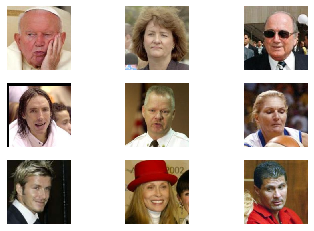

[2750 5198 4894  216 2062 2975 2961 4455 4290]
predicted class representatives


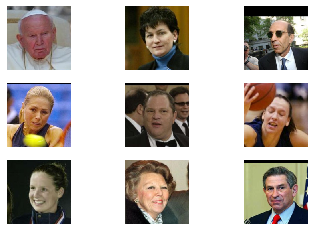

In [42]:
model = attr_rep.to(device)

import random
indices = random.sample(range(len(lfw.test_data)), 9)


images = torch.stack([lfw.test_data[i][3] for i in indices])
classes = evaluator.predict(images)

class_images = [lfw.get_images(i) for i in classes]

print([lfw.test_data[i][1] for i in indices])
print("true images")
lfw.plot_faces(images, 3)
print(classes)
print("predicted class representatives")
lfw.plot_faces(class_images, 3)

# Save model for use in application

In [102]:
class RepresationDummy:
    def __init__(self, model, knn, clazzes):
        self.model = model
        self.knn = knn
        self.clazzes = clazzes

    def __call__(self, images):
        evaluator = Eval()
        evaluator.model = self.model
        evaluator.knn = self.knn
        evaluator.clazzes = self.clazzes
        return torch.tensor(evaluator.predict_topk(images))

    def eval(self):
        return
# now in src/represation_dummy.py

In [ ]:
torch.save(RepresationDummy(evaluator.model, evaluator.knn, evaluator.clazzes), "./dummy.model")

In [96]:
dummy = torch.load("./dummy.model")

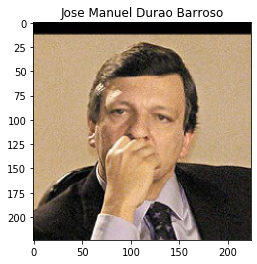

top5 representatives


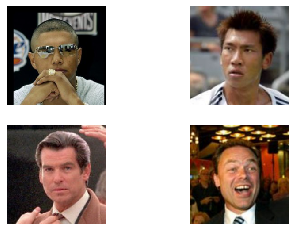

In [99]:
image_num = 1378
image = lfw.test_data[image_num][3]
pred = dummy(image.unsqueeze(0))
lfw.plot_face(image, lfw.test_data[image_num][1])
print("top5 representatives")
pred_images = [lfw.get_images(i.item()) for i in pred[0]]
lfw.plot_faces(pred_images, 2)

In [1]:
!nvidia-smi

Mon Jan  6 00:57:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 48%   41C    P0    44W / 120W |     12MiB /  8126MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  